## Benchmark for measuring performance of engineered features and models



In [1]:
import sys
sys.path.insert(0, '../../bosch_helper')
from bosch_helper import *

%matplotlib inline

/c3se/NOBACKUP/users/lyaa/conda_dir/miniconda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':16,
#          'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'gbtree', 'alpha':0,
#          'base_score':0.0058, 'colsample_bytree':0.6}

In [3]:
param_grid = {'max_depth': [13, 14, 15, 16], 
              'eta': [0.025, 0.03, 0.035],
              'silent': [1],
              'objective': ['binary:logistic'],
              'nthread': [16],
              'lambda': [3.5, 4, 4.5],
              'alpha': [0, 0.25], 
              'subsample': [0.85, 0.9, 9.5],
              'min_child_weight': [4.5, 5, 5.5],
              'booster': ['gbtree', 'dart'],
              'base_score': [0.0058], 
              'colsample_bytree': [0.5, 0.55, 0.6, 0.65]}

In [4]:
param_list = list(ParameterSampler(param_grid, n_iter=100, random_state=285749))

### Load train and test data

In [5]:
# important numeric features are imported
important_features = pd.read_csv('../benchmark_1/important_numeric_features.csv', index_col=0, header=None)
important_features = list(important_features.values.ravel())
important_features.extend(['Id', 'Response'])

x_train_numeric = pd.read_csv('../../data/train_numeric.csv.zip', index_col=0, usecols=important_features, dtype=np.float32)

y_train = x_train_numeric.Response
x_train_numeric.drop(['Response'], axis=1, inplace=True)

date_train = pd.read_csv('../benchmark_2/train_station_flow.csv.gz', index_col=0, header=None)

x_train = x_train_numeric.join(date_train)

columns = list(x_train.columns)
columns[-1] = 'station_flow'
x_train.columns = columns

x_test_numeric = pd.read_csv('../../data/test_numeric.csv.zip', index_col=0, usecols=important_features[:-1], dtype=np.float32)

date_test = pd.read_csv('../benchmark_2/test_station_flow.csv.gz', index_col=0, header=None)

x_test = x_test_numeric.join(date_test)
x_test.columns = columns

x_train.index = x_train.index.astype(np.int64)
x_test.index = x_test.index.astype(np.int64)

del x_train_numeric, x_test_numeric
gc.collect()

65

In [23]:
x_train.head()

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,...,counts_last_10080min_end,counts_next_60min_end,counts_next_150min_end,counts_next_240min_end,counts_next_480min_end,counts_next_720min_end,counts_next_1440min_end,counts_next_10080min_end,hash_encoded,count_hash
Id,,,,,,,,,,,,,,,,,,,,,
4,0.030,-0.034,-0.197,-0.179,0.116,-0.015,-0.032,0.020,0.083,-0.273,...,23249.0,453.0,896.0,1399.0,2633.0,3014.0,3015.0,10500.0,1539178,1
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8785.0,1470.0,1470.0,1470.0,1470.0,4754.0,5138.0,18092.0,848622,1
7,0.088,0.086,0.003,-0.052,0.025,-0.015,-0.072,-0.225,-0.147,0.250,...,15601.0,2912.0,2912.0,2912.0,2912.0,3560.0,3560.0,25825.0,985602,2
9,-0.036,-0.064,0.294,0.330,0.161,0.022,0.128,-0.026,-0.046,-0.253,...,28475.0,4428.0,4428.0,4428.0,4428.0,4702.0,6222.0,52645.0,205734,1
11,-0.055,-0.086,0.294,0.330,0.025,0.030,0.168,-0.169,-0.099,0.042,...,19074.0,1322.0,1322.0,1322.0,3290.0,4877.0,5572.0,30019.0,1147657,2


### Load benchmark_3 features

In [6]:
start_chunk = pd.read_csv('../benchmark_3/start_chunk.csv.gz', index_col=0)

start_chunk_train = start_chunk.loc[start_chunk.Response!=-1].drop(['Response'], axis=1)
start_chunk_test = start_chunk.loc[start_chunk.Response==-1].drop(['Response'], axis=1)

x_train = x_train.join(start_chunk_train, on='Id')
x_test = x_test.join(start_chunk_test, on='Id')

gc.collect()

35

### Load benchmark_4 features

In [7]:
n = pd.read_csv('../benchmark_4/benchmark_4_neighbors.csv.gz', index_col=0)

neighbor_train = n.loc[n.Response!=-1]
neighbor_train.drop(['Response'], axis=1, inplace=True)

neighbor_test = n.loc[n.Response==-1]
neighbor_test.drop(['Response'], axis=1, inplace=True)

print(neighbor_test.shape, neighbor_train.shape)

x_train = x_train.join(neighbor_train, on='Id')
x_test = x_test.join(neighbor_test, on='Id')

gc.collect()

(1183748, 14) (1183747, 14)


28

### Add neighbor numeric features

In [8]:
# Date + station flow data will be added to x
x = pd.concat([x_train, x_test], keys=['train', 'test'])
x.sort_index(axis=0, level='Id', inplace=True)

# Add the neighbor records
x = x.join(x.iloc[:, :150].shift(), rsuffix='_previous')
x = x.join(x.iloc[:, :150].shift(-1), rsuffix='_next')

### Load benchmark_7 features

In [9]:
time_features = pd.read_hdf('../benchmark_7/time_features_diff.hdf', 'time_features')
time_features.drop(['time_start', 'time_end', 'time_duration', 'Response'], axis=1, inplace=True)

# Find MeanTimeDiff and discard them
# time_features.columns.tolist()[-40:]

# Join to x
x = x.join(time_features.iloc[:, :-40])

### Load benchmark_8 features

In [10]:
# hash of rows and counts of duplications
hash_numeric = pd.read_hdf('benchmark_8_numeric_features_2.hdf', 'hash_numeric')

x = x.join(hash_numeric)

In [24]:
hash_numeric.head()

,,hash_encoded,count_hash
,Id,,
test,51,1791069,1170
train,725,1791069,1170
test,9221,1791069,1170
train,11549,1791069,1170
test,15017,1791069,1170


### Load zscore per week

In [11]:
# x_zscore_per_week = pd.read_hdf('benchmark_8_numeric_features_2.hdf', 'zscore_per_week')

# tmp = important_features.copy()
#tmp.remove('Response')
#tmp.remove('Id')

#x_zscore_per_week_if = x_zscore_per_week[tmp]

#x = x.join(x_zscore_per_week_if, rsuffix='_zscore')

#del x_zscore_per_week, x_zscore_per_week_if
#gc.collect()

### Load count encoding

In [12]:
# x_count_encoded = pd.read_hdf('benchmark_8_numeric_features_2.hdf', 'count_encoded')

# tmp = ['count_'+k for k in tmp]

# x_count_encoded_if = x_count_encoded[tmp]

# x_count_encoded_if.shape

# x = x.join(x_count_encoded_if)

# del x_count_encoded, x_count_encoded_if
# gc.collect()

In [13]:
x_train = x.loc['train']
x_test = x.loc['test']

del x
gc.collect()

35

### CV score based on stratified KFold with repeated models

In [14]:
# CV
# specify parameters 
# 'booster':'gbtree'
params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':20,
         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'gbtree', 'alpha':0,
         'base_score':0.0058, 'colsample_bytree':0.6}

# 'booster':'dart'
# params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':20,
#         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'dart', 'alpha':0,
#         'base_score':0.0058, 'nthread':20, 'colsample_bytree':0.6, 
#         'sample_type':'uniform', 'normalize_type':'tree', 'rate_drop':0.1, 'skip_drop':0.2, 'one_drop':True}

cv_results, clfs, running_time = cross_val_predict_skf_rm_xgb(params, x_train, y_train, 
                                                              num_boost_round=80, n_splits=5, 
                                                              n_repeats=3, random_state=70864, 
                                                              verbose_eval=True)

results = {'clfs': clfs, 'cv_results': cv_results, 'running_time': running_time}
save_pickle(results, 'results_benchmark_8_cv_only_hash.pickle')

[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.315245	test-MCC:0.314276
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.321355	test-MCC:0.319041
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.366048	test-MCC:0.372355
[3]	train-error:0.005811	test-error:0.005812	train-MCC:0.381809	test-MCC:0.395144
[4]	train-error:0.005811	test-error:0.005812	train-MCC:0.383417	test-MCC:0.394318
[5]	train-error:0.005811	test-error:0.005812	train-MCC:0.383521	test-MCC:0.396247
[6]	train-error:0.005811	test-error:0.005812	train-MCC:0.389018	test-MCC:0.398539
[7]	train-error:0.005811	test-error:0.005812	train-MCC:0.39181	test-MCC:0.398863
[8]	train-error:0.005811	test-error:0.005812	train-MCC:0.397578	test-MCC:0.400373
[9]	train-error:0.005811	test-error:0.005812	train-MCC:0.406051	test-MCC:0.404031
[10]	train-error:0.005811	test-error:0.005812	train-MCC:0.416416	test-MCC:0.406009
[11]	train-error:0.005811	test-error:0.005812	train-MCC:0.423916	test-MCC:0.408441
[12]	train-erro

[19]	train-error:0.00578	test-error:0.005795	train-MCC:0.4743	test-MCC:0.430619
[20]	train-error:0.005748	test-error:0.00577	train-MCC:0.475359	test-MCC:0.431558
[21]	train-error:0.005719	test-error:0.00574	train-MCC:0.47697	test-MCC:0.430153
[22]	train-error:0.005668	test-error:0.005711	train-MCC:0.481645	test-MCC:0.43125
[23]	train-error:0.005629	test-error:0.005664	train-MCC:0.482265	test-MCC:0.428867
[24]	train-error:0.005561	test-error:0.005605	train-MCC:0.484961	test-MCC:0.428716
[25]	train-error:0.005487	test-error:0.005563	train-MCC:0.486037	test-MCC:0.43035
[26]	train-error:0.005421	test-error:0.005512	train-MCC:0.489587	test-MCC:0.429878
[27]	train-error:0.005356	test-error:0.005474	train-MCC:0.491659	test-MCC:0.428256
[28]	train-error:0.005306	test-error:0.005419	train-MCC:0.493828	test-MCC:0.429076
[29]	train-error:0.005238	test-error:0.005356	train-MCC:0.49441	test-MCC:0.430312
[30]	train-error:0.005176	test-error:0.005301	train-MCC:0.495137	test-MCC:0.4299
[31]	train-erro

[38]	train-error:0.004916	test-error:0.005094	train-MCC:0.497083	test-MCC:0.450594
[39]	train-error:0.004902	test-error:0.005081	train-MCC:0.497405	test-MCC:0.451695
[40]	train-error:0.004895	test-error:0.00506	train-MCC:0.498267	test-MCC:0.450785
[41]	train-error:0.00487	test-error:0.005043	train-MCC:0.499584	test-MCC:0.451419
[42]	train-error:0.004859	test-error:0.005035	train-MCC:0.502559	test-MCC:0.451918
[43]	train-error:0.004842	test-error:0.005014	train-MCC:0.50399	test-MCC:0.453408
[44]	train-error:0.004827	test-error:0.005001	train-MCC:0.504894	test-MCC:0.452241
[45]	train-error:0.00481	test-error:0.004988	train-MCC:0.507857	test-MCC:0.452752
[46]	train-error:0.004794	test-error:0.004984	train-MCC:0.509595	test-MCC:0.452392
[47]	train-error:0.004778	test-error:0.00498	train-MCC:0.510597	test-MCC:0.45298
[48]	train-error:0.00477	test-error:0.004967	train-MCC:0.512494	test-MCC:0.453024
[49]	train-error:0.004765	test-error:0.004963	train-MCC:0.514911	test-MCC:0.45376
[50]	train-e

[57]	train-error:0.004719	test-error:0.0049	train-MCC:0.535456	test-MCC:0.445665
[58]	train-error:0.004711	test-error:0.004895	train-MCC:0.536578	test-MCC:0.444943
[59]	train-error:0.004696	test-error:0.004904	train-MCC:0.539339	test-MCC:0.446196
[60]	train-error:0.004684	test-error:0.004887	train-MCC:0.540456	test-MCC:0.445224
[61]	train-error:0.00468	test-error:0.004883	train-MCC:0.542744	test-MCC:0.446197
[62]	train-error:0.004665	test-error:0.004887	train-MCC:0.545033	test-MCC:0.446972
[63]	train-error:0.004655	test-error:0.004874	train-MCC:0.547203	test-MCC:0.446546
[64]	train-error:0.004642	test-error:0.004874	train-MCC:0.550714	test-MCC:0.446443
[65]	train-error:0.004635	test-error:0.00487	train-MCC:0.552829	test-MCC:0.447376
[66]	train-error:0.004621	test-error:0.004862	train-MCC:0.556198	test-MCC:0.447099
[67]	train-error:0.004609	test-error:0.004862	train-MCC:0.557393	test-MCC:0.448506
[68]	train-error:0.0046	test-error:0.004862	train-MCC:0.560195	test-MCC:0.450308
[69]	train

[76]	train-error:0.004507	test-error:0.004731	train-MCC:0.582045	test-MCC:0.450359
[77]	train-error:0.004495	test-error:0.004731	train-MCC:0.584248	test-MCC:0.451031
[78]	train-error:0.004489	test-error:0.004718	train-MCC:0.587513	test-MCC:0.451031
[79]	train-error:0.004482	test-error:0.004718	train-MCC:0.589084	test-MCC:0.451362
Repeat 0, split 4, test MCC = 0.451, running time = 7.471 min
[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.29652	test-MCC:0.291361
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.316566	test-MCC:0.32937
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.334343	test-MCC:0.332879
[3]	train-error:0.005811	test-error:0.005812	train-MCC:0.361504	test-MCC:0.366952
[4]	train-error:0.005811	test-error:0.005812	train-MCC:0.371399	test-MCC:0.377991
[5]	train-error:0.005811	test-error:0.005812	train-MCC:0.377193	test-MCC:0.380176
[6]	train-error:0.005811	test-error:0.005812	train-MCC:0.3867	test-MCC:0.384448
[7]	train-error:0.005811	test-error:

[14]	train-error:0.005809	test-error:0.005812	train-MCC:0.432313	test-MCC:0.404682
[15]	train-error:0.005809	test-error:0.005812	train-MCC:0.439187	test-MCC:0.408338
[16]	train-error:0.005807	test-error:0.005812	train-MCC:0.445364	test-MCC:0.417214
[17]	train-error:0.005807	test-error:0.005812	train-MCC:0.447315	test-MCC:0.419125
[18]	train-error:0.005805	test-error:0.005812	train-MCC:0.453595	test-MCC:0.418291
[19]	train-error:0.0058	test-error:0.005812	train-MCC:0.45845	test-MCC:0.419877
[20]	train-error:0.005793	test-error:0.005808	train-MCC:0.461964	test-MCC:0.422952
[21]	train-error:0.00575	test-error:0.005774	train-MCC:0.464809	test-MCC:0.423297
[22]	train-error:0.00571	test-error:0.005749	train-MCC:0.470142	test-MCC:0.423051
[23]	train-error:0.005638	test-error:0.005677	train-MCC:0.473615	test-MCC:0.425752
[24]	train-error:0.005541	test-error:0.005597	train-MCC:0.478134	test-MCC:0.425657
[25]	train-error:0.00546	test-error:0.005529	train-MCC:0.48231	test-MCC:0.4273
[26]	train-er

[33]	train-error:0.005064	test-error:0.005212	train-MCC:0.494186	test-MCC:0.443556
[34]	train-error:0.005036	test-error:0.005187	train-MCC:0.495085	test-MCC:0.444642
[35]	train-error:0.005004	test-error:0.00517	train-MCC:0.497836	test-MCC:0.443578
[36]	train-error:0.004981	test-error:0.00514	train-MCC:0.499351	test-MCC:0.444642
[37]	train-error:0.004959	test-error:0.005111	train-MCC:0.501262	test-MCC:0.444801
[38]	train-error:0.004938	test-error:0.005098	train-MCC:0.502574	test-MCC:0.446388
[39]	train-error:0.004927	test-error:0.005081	train-MCC:0.503442	test-MCC:0.446369
[40]	train-error:0.004903	test-error:0.00506	train-MCC:0.504177	test-MCC:0.446708
[41]	train-error:0.00488	test-error:0.005031	train-MCC:0.505778	test-MCC:0.444951
[42]	train-error:0.004867	test-error:0.005018	train-MCC:0.506103	test-MCC:0.445427
[43]	train-error:0.00485	test-error:0.00501	train-MCC:0.506549	test-MCC:0.445697
[44]	train-error:0.004829	test-error:0.004997	train-MCC:0.507395	test-MCC:0.445818
[45]	train

[52]	train-error:0.004729	test-error:0.004883	train-MCC:0.52986	test-MCC:0.444644
[53]	train-error:0.004714	test-error:0.004883	train-MCC:0.532479	test-MCC:0.446391
[54]	train-error:0.004701	test-error:0.004866	train-MCC:0.533495	test-MCC:0.446391
[55]	train-error:0.004686	test-error:0.00487	train-MCC:0.535608	test-MCC:0.445725
[56]	train-error:0.004677	test-error:0.004866	train-MCC:0.538205	test-MCC:0.446172
[57]	train-error:0.004659	test-error:0.004866	train-MCC:0.541139	test-MCC:0.446172
[58]	train-error:0.004643	test-error:0.004862	train-MCC:0.542323	test-MCC:0.446197
[59]	train-error:0.004624	test-error:0.004853	train-MCC:0.544898	test-MCC:0.447534
[60]	train-error:0.004617	test-error:0.004845	train-MCC:0.545574	test-MCC:0.448895
[61]	train-error:0.004596	test-error:0.004841	train-MCC:0.547795	test-MCC:0.447967
[62]	train-error:0.004578	test-error:0.004832	train-MCC:0.549458	test-MCC:0.446732
[63]	train-error:0.004566	test-error:0.004828	train-MCC:0.552499	test-MCC:0.446612
[64]	t

[71]	train-error:0.004572	test-error:0.004743	train-MCC:0.551468	test-MCC:0.446058
[72]	train-error:0.004562	test-error:0.004739	train-MCC:0.553612	test-MCC:0.446442
[73]	train-error:0.004561	test-error:0.004743	train-MCC:0.555485	test-MCC:0.447062
[74]	train-error:0.004548	test-error:0.004743	train-MCC:0.557095	test-MCC:0.446103
[75]	train-error:0.004546	test-error:0.004739	train-MCC:0.560215	test-MCC:0.446909
[76]	train-error:0.00454	test-error:0.004735	train-MCC:0.561798	test-MCC:0.447698
[77]	train-error:0.00453	test-error:0.004727	train-MCC:0.564763	test-MCC:0.448062
[78]	train-error:0.004527	test-error:0.004727	train-MCC:0.566358	test-MCC:0.447125
[79]	train-error:0.004524	test-error:0.004722	train-MCC:0.568388	test-MCC:0.446482
Repeat 1, split 4, test MCC = 0.446, running time = 6.549 min
[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.305861	test-MCC:0.303369
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.324563	test-MCC:0.327323
[2]	train-error:0.005811	test

[9]	train-error:0.005811	test-error:0.005812	train-MCC:0.402839	test-MCC:0.3808
[10]	train-error:0.005811	test-error:0.005812	train-MCC:0.414591	test-MCC:0.386488
[11]	train-error:0.005811	test-error:0.005812	train-MCC:0.420277	test-MCC:0.386362
[12]	train-error:0.005811	test-error:0.005812	train-MCC:0.432313	test-MCC:0.389063
[13]	train-error:0.005811	test-error:0.005812	train-MCC:0.437489	test-MCC:0.394358
[14]	train-error:0.005809	test-error:0.005812	train-MCC:0.442964	test-MCC:0.394187
[15]	train-error:0.005809	test-error:0.005812	train-MCC:0.447935	test-MCC:0.395264
[16]	train-error:0.005809	test-error:0.005812	train-MCC:0.453085	test-MCC:0.397069
[17]	train-error:0.005809	test-error:0.005812	train-MCC:0.457068	test-MCC:0.398989
[18]	train-error:0.005807	test-error:0.005812	train-MCC:0.461804	test-MCC:0.401631
[19]	train-error:0.0058	test-error:0.005808	train-MCC:0.467519	test-MCC:0.405359
[20]	train-error:0.005755	test-error:0.005782	train-MCC:0.47077	test-MCC:0.409603
[21]	train

[28]	train-error:0.005242	test-error:0.005305	train-MCC:0.480106	test-MCC:0.442655
[29]	train-error:0.00519	test-error:0.005254	train-MCC:0.482403	test-MCC:0.445283
[30]	train-error:0.005156	test-error:0.005238	train-MCC:0.483538	test-MCC:0.443515
[31]	train-error:0.005115	test-error:0.005195	train-MCC:0.485729	test-MCC:0.446671
[32]	train-error:0.005083	test-error:0.005157	train-MCC:0.486938	test-MCC:0.44628
[33]	train-error:0.005048	test-error:0.005136	train-MCC:0.487767	test-MCC:0.446484
[34]	train-error:0.005014	test-error:0.005124	train-MCC:0.489183	test-MCC:0.447267
[35]	train-error:0.004998	test-error:0.005107	train-MCC:0.489999	test-MCC:0.451254
[36]	train-error:0.004979	test-error:0.005107	train-MCC:0.491355	test-MCC:0.448466
[37]	train-error:0.004954	test-error:0.005102	train-MCC:0.492913	test-MCC:0.448066
[38]	train-error:0.004931	test-error:0.005086	train-MCC:0.495549	test-MCC:0.448278
[39]	train-error:0.004918	test-error:0.005073	train-MCC:0.496506	test-MCC:0.448278
[40]	t

[47]	train-error:0.004767	test-error:0.004895	train-MCC:0.527496	test-MCC:0.444595
[48]	train-error:0.004749	test-error:0.0049	train-MCC:0.529451	test-MCC:0.444635
[49]	train-error:0.004741	test-error:0.004887	train-MCC:0.532205	test-MCC:0.445543
[50]	train-error:0.004729	test-error:0.004879	train-MCC:0.533716	test-MCC:0.445411
[51]	train-error:0.004712	test-error:0.00487	train-MCC:0.534935	test-MCC:0.446388
[52]	train-error:0.004698	test-error:0.00487	train-MCC:0.537873	test-MCC:0.445808
[53]	train-error:0.004686	test-error:0.00487	train-MCC:0.540964	test-MCC:0.44677
[54]	train-error:0.004678	test-error:0.004866	train-MCC:0.542593	test-MCC:0.447317
[55]	train-error:0.004663	test-error:0.00487	train-MCC:0.545728	test-MCC:0.448042
[56]	train-error:0.004653	test-error:0.00487	train-MCC:0.547275	test-MCC:0.447814
[57]	train-error:0.004639	test-error:0.00487	train-MCC:0.55085	test-MCC:0.448087
[58]	train-error:0.004638	test-error:0.004857	train-MCC:0.554159	test-MCC:0.449581
[59]	train-err

[66]	train-error:0.004556	test-error:0.004765	train-MCC:0.550121	test-MCC:0.456206
[67]	train-error:0.004548	test-error:0.004752	train-MCC:0.553451	test-MCC:0.457684
[68]	train-error:0.004542	test-error:0.004752	train-MCC:0.55514	test-MCC:0.456883
[69]	train-error:0.004535	test-error:0.004752	train-MCC:0.556322	test-MCC:0.456883
[70]	train-error:0.004527	test-error:0.004743	train-MCC:0.558036	test-MCC:0.456612
[71]	train-error:0.004523	test-error:0.004739	train-MCC:0.56233	test-MCC:0.456119
[72]	train-error:0.004518	test-error:0.004735	train-MCC:0.563207	test-MCC:0.455849
[73]	train-error:0.004516	test-error:0.004735	train-MCC:0.564614	test-MCC:0.45692
[74]	train-error:0.004509	test-error:0.004731	train-MCC:0.567116	test-MCC:0.456583
[75]	train-error:0.004507	test-error:0.004727	train-MCC:0.568361	test-MCC:0.456583
[76]	train-error:0.004506	test-error:0.004722	train-MCC:0.569456	test-MCC:0.457403
[77]	train-error:0.004503	test-error:0.00471	train-MCC:0.571077	test-MCC:0.45789
[78]	trai

In [15]:
cv_train_mean = cv_results['train'].mean(axis=1)
cv_train_std = cv_results['train'].std(axis=1)
cv_test_mean = cv_results['test'].mean(axis=1)
cv_test_std = cv_results['test'].std(axis=1)

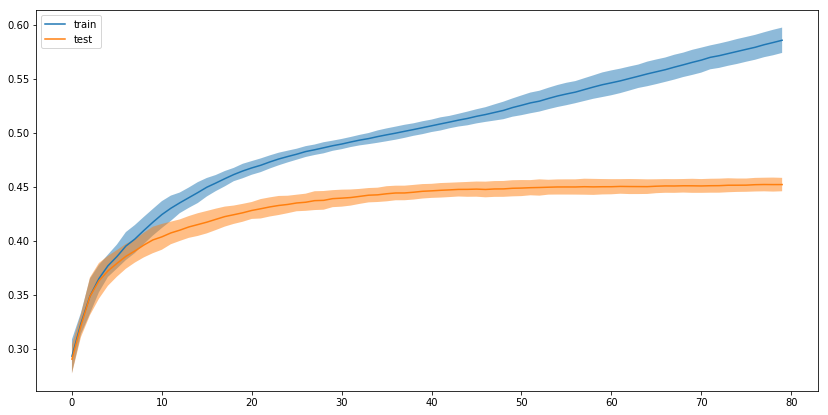

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(cv_train_mean)), cv_train_mean)
plt.fill_between(np.arange(len(cv_train_mean)), cv_train_mean-cv_train_std, cv_train_mean+cv_train_std, alpha=0.5)
plt.plot(np.arange(len(cv_train_mean)), cv_test_mean)
plt.fill_between(np.arange(len(cv_test_mean)), cv_test_mean-cv_test_std, cv_test_mean+cv_test_std, alpha=0.5)
plt.legend(['train', 'test'])

[0]	train-error:0.005811	train-MCC:0.306396
[1]	train-error:0.005811	train-MCC:0.339485
[2]	train-error:0.005811	train-MCC:0.369317
[3]	train-error:0.005811	train-MCC:0.372731
[4]	train-error:0.005811	train-MCC:0.383151
[5]	train-error:0.005811	train-MCC:0.391325
[6]	train-error:0.005811	train-MCC:0.399223
[7]	train-error:0.005811	train-MCC:0.411606
[8]	train-error:0.005811	train-MCC:0.416138
[9]	train-error:0.005811	train-MCC:0.41999
[10]	train-error:0.005811	train-MCC:0.431855
[11]	train-error:0.005811	train-MCC:0.438718
[12]	train-error:0.005811	train-MCC:0.441295
[13]	train-error:0.005811	train-MCC:0.444503
[14]	train-error:0.005811	train-MCC:0.447981
[15]	train-error:0.005811	train-MCC:0.452005
[16]	train-error:0.005811	train-MCC:0.455592
[17]	train-error:0.00581	train-MCC:0.459684
[18]	train-error:0.005795	train-MCC:0.461783
[19]	train-error:0.005738	train-MCC:0.466827
[20]	train-error:0.005709	train-MCC:0.468707
[21]	train-error:0.00565	train-MCC:0.469718
[22]	train-error:0.0055

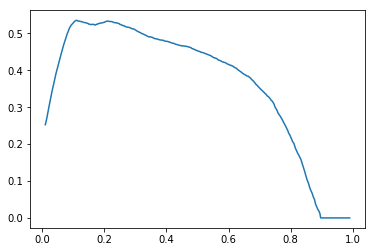

In [17]:
# Train the model
dtrain = xgb.DMatrix(x_train, label=y_train)
params['seed'] = 28537894
clf = xgb.train(params, dtrain, num_boost_round=60,
               feval=mcc_eval, evals=[(dtrain, 'train')])

y_train_pred = clf.predict(dtrain)

# Find best threshold 
thresholds = np.linspace(0.01, 0.99, 400)
mcc = np.array([matthews_corrcoef(y_train, y_train_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]

print('Optimal MCC = {:.3f}'.format(mcc.max()))
print('Optimal threshold = {:.3f}'.format(best_threshold))

### Predict on test data

In [18]:
dtest = xgb.DMatrix(x_test)
y_test_pred = clf.predict(dtest)
y_test_pred_int = (y_test_pred>best_threshold).astype(int)

sub = pd.read_csv("../../data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("submission_benchmark_8_only_hash.csv.gz", compression="gzip")

In [22]:
cv_test_mean[60]+cv_test_std[60]

cv_test_mean[60]-cv_test_std[60]

cv_test_mean[79]

cv_test_std[60]

0.007014248109587888

In [20]:
cv_test_mean[60]+cv_test_std[60]

0.45701364810958783

With only hash of numeric features
- CV `n_estimators=80`: MCC Score mean = 0.452, std = 0.006
- CV `n_estimators=60`: MCC Score mean = 0.449999, std = 0.007
- LB `n_estimators=60`: Private LB = 0.41335, public LB = 0.41525